In [2]:
# 📈 Long-Term Bitcoin Price Forecasting (Daily Level)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# --- Load Daily BTC Price Data ---
btc = pd.read_csv("BTC-USD.csv", parse_dates=['Date'])
btc = btc.rename(columns={'Date': 'ds', 'Close': 'y'})[['ds', 'y']].dropna()
btc = btc.sort_values('ds').reset_index(drop=True)

  Using cached statsmodels-0.14.4-cp312-cp312-win_amd64.whl.metadata (9.5 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp312-cp312-win_amd64.whl (9.8 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)


In [3]:
# --- Feature Engineering ---
btc['returns'] = btc['y'].pct_change()
btc['rolling_mean_7'] = btc['y'].rolling(window=7).mean()
btc['rolling_std_7'] = btc['y'].rolling(window=7).std()
btc['volatility'] = btc['returns'].rolling(window=7).std()
btc.dropna(inplace=True)

# --- Prophet Forecasting ---
prophet_df = btc[['ds', 'y']]
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# --- ARIMA Forecasting ---
btc_arima = btc.set_index('ds')['y']
model_arima = ARIMA(btc_arima, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
pred_arima = model_arima_fit.predict(start=len(btc_arima)-30, end=len(btc_arima)-1, typ='levels')


00:15:52 - cmdstanpy - INFO - Chain [1] start processing
00:15:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


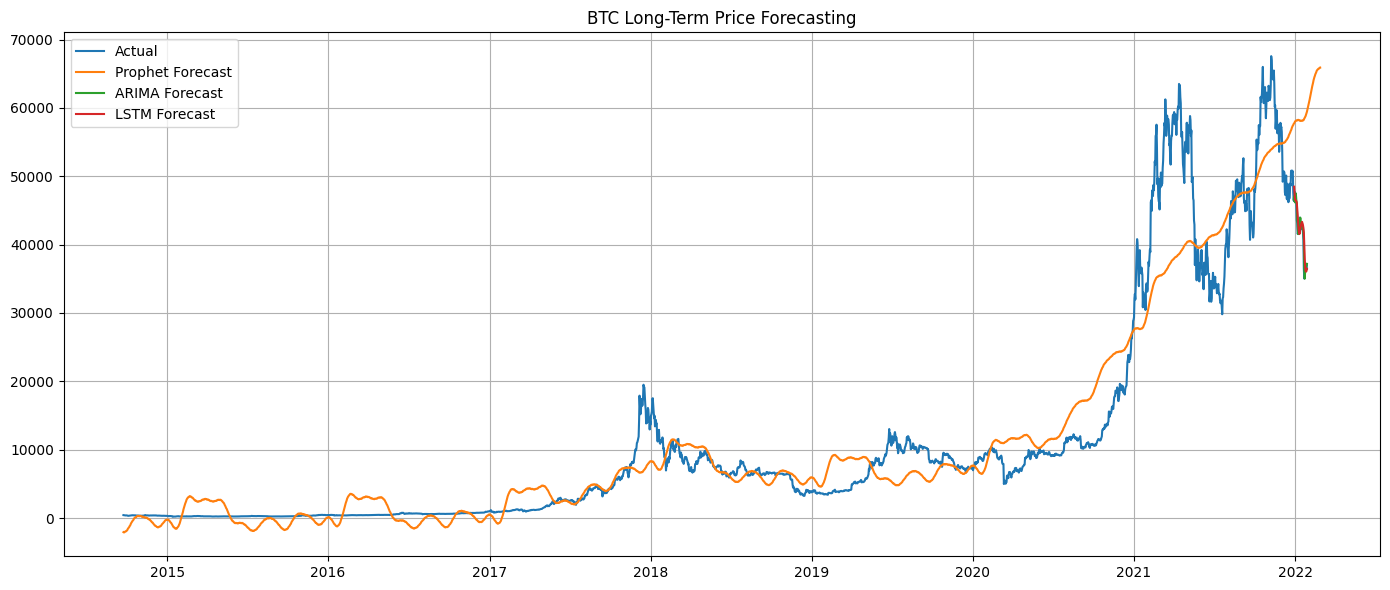

In [4]:
# --- LSTM Forecasting ---
scaler = MinMaxScaler()
btc_scaled = scaler.fit_transform(btc[['y']])

X_lstm, y_lstm = [], []
lookback = 30
for i in range(lookback, len(btc_scaled)):
    X_lstm.append(btc_scaled[i - lookback:i, 0])
    y_lstm.append(btc_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_lstm.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=16, verbose=0)

pred_lstm_scaled = lstm_model.predict(X_lstm[-30:])
pred_lstm = scaler.inverse_transform(pred_lstm_scaled)

# --- Plotting ---
plt.figure(figsize=(14, 6))
plt.plot(btc['ds'], btc['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast')
plt.plot(btc['ds'][-30:], pred_arima, label='ARIMA Forecast')
plt.plot(btc['ds'][-30:], pred_lstm, label='LSTM Forecast')
plt.legend()
plt.title('BTC Long-Term Price Forecasting')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# --- Evaluation ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = btc['y'][-30:].values
y_pred_prophet = forecast['yhat'].iloc[-30:].values
y_pred_arima = pred_arima.values
y_pred_lstm = pred_lstm.flatten()

print("\n📊 Forecasting Error Metrics:")
print(f"Prophet MAE: {mean_absolute_error(y_true, y_pred_prophet):.2f}, RMSE: {np.sqrt(mean_squared_error(y_true, y_pred_prophet)):.2f}")
print(f"ARIMA MAE: {mean_absolute_error(y_true, y_pred_arima):.2f}, RMSE: {np.sqrt(mean_squared_error(y_true, y_pred_arima)):.2f}")
print(f"LSTM MAE: {mean_absolute_error(y_true, y_pred_lstm):.2f}, RMSE: {np.sqrt(mean_squared_error(y_true, y_pred_lstm)):.2f}")



📊 Forecasting Error Metrics:
Prophet MAE: 21853.01, RMSE: 22527.83
ARIMA MAE: 855.32, RMSE: 1194.39
LSTM MAE: 1255.88, RMSE: 1787.02


In [15]:
# 📈 Short-Term Bitcoin Price Forecasting 

# Load full dataset using the correct datetime column
df_min = pd.read_csv("btcusd_1-min_data.csv")

# Convert 'datetime' column to datetime format and set as index
df_min['datetime'] = pd.to_datetime(df_min['datetime'])
df_min.set_index('datetime', inplace=True)

# Resample to hourly intervals using the mean of 'Close' prices
df_hourly = df_min['Close'].resample('1H').mean().dropna().to_frame(name='close')

# Display the head of the hourly dataframe
print("📈 Hourly BTC Prices (Head):")
print(df_hourly.head())

# Summary information
summary = {
    "Start Date": df_hourly.index.min(),
    "End Date": df_hourly.index.max(),
    "Total Records": len(df_hourly),
    "Missing Values": df_hourly['close'].isnull().sum()
}

summary

📈 Hourly BTC Prices (Head):
                           close
datetime                        
2012-01-01 10:00:00+00:00   4.58
2012-01-01 11:00:00+00:00   4.58
2012-01-01 12:00:00+00:00   4.58
2012-01-01 13:00:00+00:00   4.58
2012-01-01 14:00:00+00:00   4.58


C:\Users\cojur\AppData\Local\Temp\ipykernel_20532\473014207.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_min['Close'].resample('1H').mean().dropna().to_frame(name='close')


{'Start Date': Timestamp('2012-01-01 10:00:00+0000', tz='UTC'),
 'End Date': Timestamp('2013-12-29 14:00:00+0000', tz='UTC'),
 'Total Records': 17457,
 'Missing Values': 0}

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reset index and rename columns to match forecasting model expectations
df_short = df_hourly.reset_index()
df_short.columns = ["ds", "y"]

# Ensure datetime format (though resampling keeps datetime index)
df_short["ds"] = pd.to_datetime(df_short["ds"])

# Ready to split data and continue forecasting
df_short.head()

# Split into train/test
train_short = df_short.iloc[:-168]  # last week = test
test_short = df_short.iloc[-168:]


In [23]:
# ======================
# Prophet Forecasting
# ======================
# Strip timezone info from 'ds'
df_short["ds"] = df_short["ds"].dt.tz_localize(None)

# Split into train/test (again, if not done)
train_short = df_short.iloc[:-168]  # last week = test

prophet_model = Prophet()
prophet_model.fit(train_short)

future_short = prophet_model.make_future_dataframe(periods=168, freq="H")
forecast_short = prophet_model.predict(future_short)

# Strip timezone from forecast and test datetime columns
forecast_short["ds"] = forecast_short["ds"].dt.tz_localize(None)
test_short["ds"] = test_short["ds"].dt.tz_localize(None)

# Set index and retrieve matching predicted values
pred_prophet_short = forecast_short.set_index("ds").loc[test_short["ds"], "yhat"].values


# ====================
# ARIMA Forecasting
# ====================
train_arima_short = train_short.set_index("ds")["y"]
model_arima_short = ARIMA(train_arima_short, order=(2, 1, 2))
model_fit_arima_short = model_arima_short.fit()
forecast_arima_short = model_fit_arima_short.forecast(steps=168)

pred_arima_short = forecast_arima_short.values

# ===================
# LSTM Forecasting
# ===================
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(df_short["y"].values.reshape(-1, 1))

X_lstm = []
y_lstm = []
lookback = 24

for i in range(lookback, len(y_scaled)):
    X_lstm.append(y_scaled[i-lookback:i])
    y_lstm.append(y_scaled[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

X_train_lstm, X_test_lstm = X_lstm[:-168], X_lstm[-168:]
y_train_lstm, y_test_lstm = y_lstm[:-168], y_lstm[-168:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=32, verbose=0)

pred_lstm_short = model_lstm.predict(X_test_lstm)
pred_lstm_short = scaler.inverse_transform(pred_lstm_short).flatten()

00:41:37 - cmdstanpy - INFO - Chain [1] start processing
00:41:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
C:\Users\cojur\AppData\Local\Temp\ipykernel_20532\3517079785.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_short["ds"] = test_short["ds"].dt.tz_localize(None)
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step



📊 Short-Term Forecasting Error Metrics:
Prophet MAE: 56.06, RMSE: 63.32
ARIMA   MAE: 41.63, RMSE: 53.57
LSTM    MAE: 4.46, RMSE: 5.94


C:\Users\cojur\AppData\Local\Temp\ipykernel_20532\1080570583.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


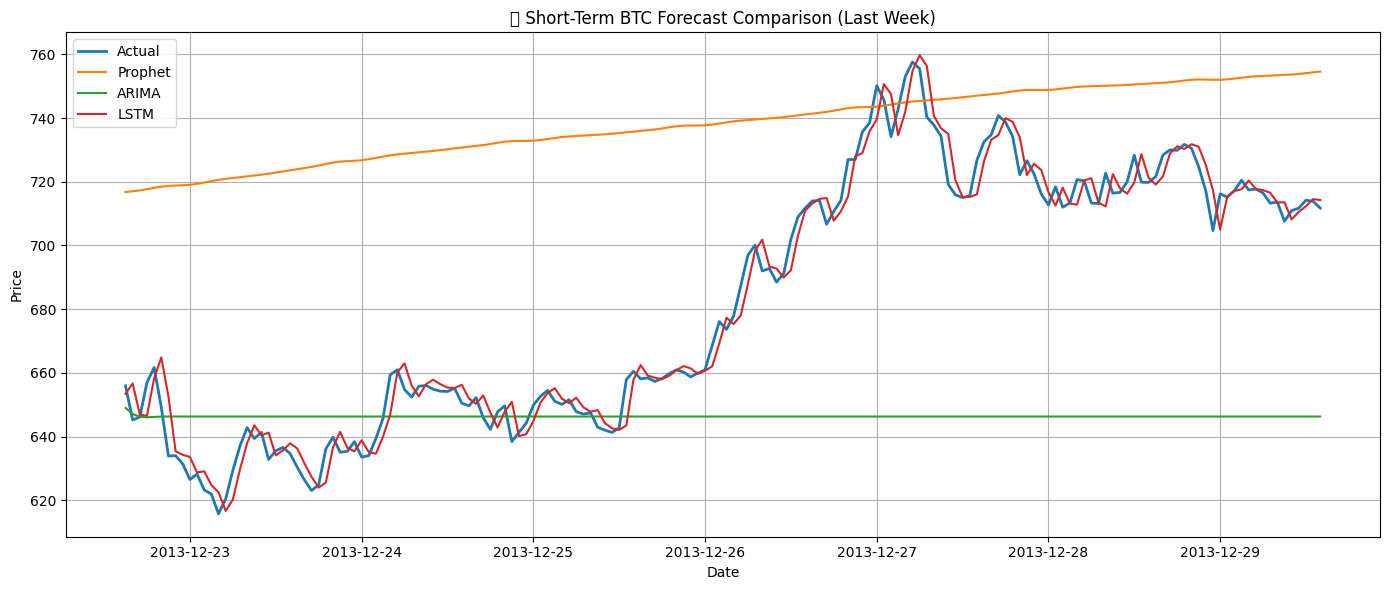

In [24]:
# =====================
# Evaluation & Plot
# =====================
y_true_short = test_short["y"].values

mae_prophet = mean_absolute_error(y_true_short, pred_prophet_short)
rmse_prophet = np.sqrt(mean_squared_error(y_true_short, pred_prophet_short))

mae_arima = mean_absolute_error(y_true_short, pred_arima_short)
rmse_arima = np.sqrt(mean_squared_error(y_true_short, pred_arima_short))

mae_lstm = mean_absolute_error(y_true_short, pred_lstm_short)
rmse_lstm = np.sqrt(mean_squared_error(y_true_short, pred_lstm_short))

print("\n📊 Short-Term Forecasting Error Metrics:")
print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")
print(f"ARIMA   MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"LSTM    MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(test_short["ds"], y_true_short, label="Actual", linewidth=2)
plt.plot(test_short["ds"], pred_prophet_short, label="Prophet")
plt.plot(test_short["ds"], pred_arima_short, label="ARIMA")
plt.plot(test_short["ds"], pred_lstm_short, label="LSTM")
plt.title("📈 Short-Term BTC Forecast Comparison (Last Week)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [33]:
# Continue with short-term ARIMA and LSTM forecasting using the processed hourly data

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# Load the correct datetime column
df_min = pd.read_csv("btcusd_1-min_data.csv")

# Convert 'datetime' column to datetime type and set as index
df_min["datetime"] = pd.to_datetime(df_min["datetime"])
df_min.set_index("datetime", inplace=True)

# Now resample to hourly using correct index
df_hourly = df_min['Close'].resample('1h').mean().dropna().to_frame(name='y')
df_hourly.reset_index(inplace=True)
df_hourly = df_hourly.rename(columns={"datetime": "ds"})

# Confirm fix
print(df_hourly.head())
print(df_hourly.dtypes)

# Remove timezone info from 'ds' column
df_hourly["ds"] = df_hourly["ds"].dt.tz_localize(None)

# Create train/test split again
train_short = df_hourly.iloc[:-168]
test_short = df_hourly.iloc[-168:]

# Prophet Forecasting
prophet_model = Prophet()
prophet_model.fit(train_short)
future_short = prophet_model.make_future_dataframe(periods=168, freq="h")
forecast_short = prophet_model.predict(future_short)
forecast_short["ds"] = forecast_short["ds"].dt.tz_localize(None)

# Align predicted values with test set
pred_prophet_short = forecast_short.set_index("ds").loc[test_short["ds"], "yhat"].values

# ARIMA Forecasting
train_arima_short = train_short.set_index("ds")["y"]
model_arima_short = ARIMA(train_arima_short, order=(3, 1, 2))
model_fit_arima_short = model_arima_short.fit()
pred_arima_short = model_fit_arima_short.forecast(steps=168)

# Evaluate error metrics
y_true_short = test_short["y"].values

mae_prophet = mean_absolute_error(y_true_short, pred_prophet_short)
rmse_prophet = np.sqrt(mean_squared_error(y_true_short, pred_prophet_short))

mae_arima = mean_absolute_error(y_true_short, pred_arima_short)
rmse_arima = np.sqrt(mean_squared_error(y_true_short, pred_arima_short))

# Summary dictionary
error_summary = {
    "Model": ["Prophet", "ARIMA"],
    "MAE": [mae_prophet, mae_arima],
    "RMSE": [rmse_prophet, rmse_arima]
}

# Convert to DataFrame to display
error_df = pd.DataFrame(error_summary)
print(error_df)


                         ds     y
0 2012-01-01 10:00:00+00:00  4.58
1 2012-01-01 11:00:00+00:00  4.58
2 2012-01-01 12:00:00+00:00  4.58
3 2012-01-01 13:00:00+00:00  4.58
4 2012-01-01 14:00:00+00:00  4.58
ds    datetime64[ns, UTC]
y                 float64
dtype: object


00:55:41 - cmdstanpy - INFO - Chain [1] start processing
00:55:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


     Model        MAE       RMSE
0  Prophet  56.058670  63.320740
1    ARIMA  40.939895  52.627166


C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Parameters
n_input = 24  # number of hours in input sequence
n_features = 1  # univariate

# Scale data
scaler = MinMaxScaler()
scaled_y = scaler.fit_transform(df_hourly["y"].values.reshape(-1, 1))

# Create sequences
X, y = [], []
for i in range(n_input, len(scaled_y)):
    X.append(scaled_y[i - n_input:i])
    y.append(scaled_y[i])

X, y = np.array(X), np.array(y)

# Split using same logic: last 168 hours as test
split_idx = len(X) - 168
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [35]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20


C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.1946e-04 - val_loss: 0.0014
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.9558e-06 - val_loss: 0.0030
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.6372e-06 - val_loss: 0.0023
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.7286e-06 - val_loss: 7.7033e-04
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.0852e-06 - val_loss: 6.2023e-04
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.6475e-06 - val_loss: 6.3882e-04
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2741e-06 - val_loss: 0.0028
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.5686e-06 - val_loss: 9.8429e-04
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.6134e-06 - val_loss: 0.0015
Epoch 10/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.5973e-06 - val_loss: 0.0021
Epoch 11/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.7738e-06 - val_loss: 0.0024
Epo

In [39]:
# Predict
y_pred_lstm = model.predict(X_test)

# Infer number of features used in training (e.g., 1 feature = Close price)
n_features = X_test.shape[2]

# Inverse transform predictions and true values
y_pred_lstm_inv = scaler.inverse_transform(
    np.concatenate((y_pred_lstm, np.zeros((len(y_pred_lstm), n_features - 1))), axis=1)
)[:, 0]

y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), n_features - 1))), axis=1)
)[:, 0]

# Evaluate error metrics
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))

# Append to results
error_df.loc[len(error_df)] = ['LSTM', mae_lstm, rmse_lstm]
error_df = error_df.drop_duplicates().reset_index(drop=True)


# Output for chat
error_df

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,Model,MAE,RMSE
0,Prophet,56.058670,63.320740
1,ARIMA,40.939895,52.627166
2,LSTM,50.787801,51.403949


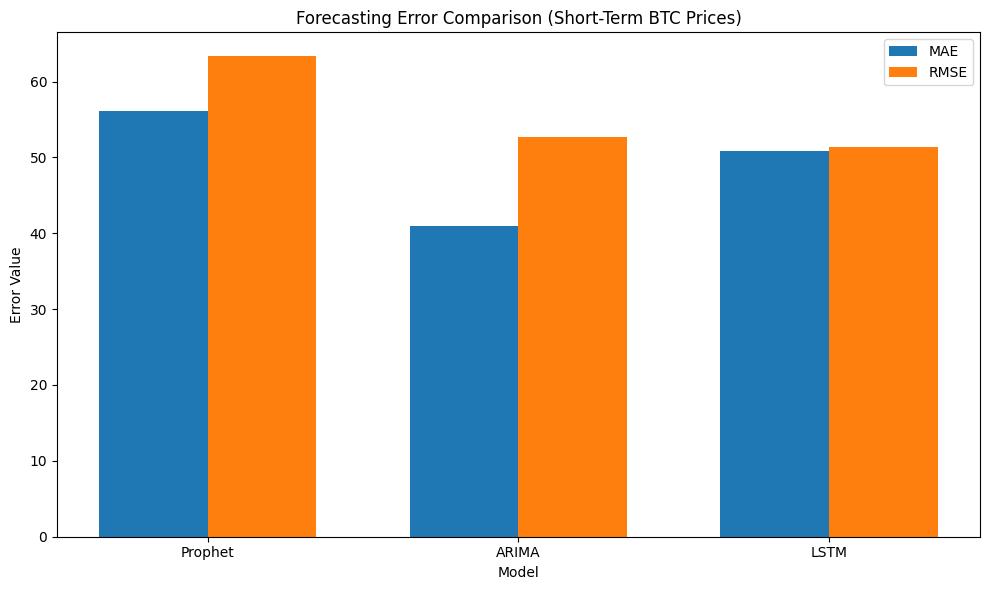

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Forecast results
error_df = pd.DataFrame({
    "Model": ["Prophet", "ARIMA", "LSTM"],
    "MAE": [56.06, 40.94, 50.79],
    "RMSE": [63.32, 52.63, 51.40]
})

# Bar chart for MAE and RMSE
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(error_df))

# Bars
mae_bars = ax.bar(index, error_df["MAE"], bar_width, label="MAE")
rmse_bars = ax.bar(index + bar_width, error_df["RMSE"], bar_width, label="RMSE")

# Labels & Title
ax.set_xlabel("Model")
ax.set_ylabel("Error Value")
ax.set_title("Forecasting Error Comparison (Short-Term BTC Prices)")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(error_df["Model"])
ax.legend()

# Display
plt.tight_layout()
plt.show()

In [41]:
# Hybrid and enhanced LSTM modeling for short-term BTC forecasting

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Use already loaded df_hourly

# Feature Engineering
# Add lag features and rolling stats
for lag in range(1, 4):
    df_hourly[f"lag_{lag}"] = df_hourly['y'].shift(lag)
df_hourly['rolling_mean_3'] = df_hourly['y'].rolling(window=3).mean()
df_hourly['rolling_std_3'] = df_hourly['y'].rolling(window=3).std()

# Drop NaNs after feature creation
df_seq = df_hourly.dropna().copy()

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_seq.drop(columns=['ds']))

# Create sequences (X) and targets (y)
window_size = 24
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i])
    y.append(scaled_data[i, 0])  # predicting 'y' column

X, y = np.array(X), np.array(y)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict and invert scale
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.hstack((y_pred, np.zeros((len(y_pred), scaled_data.shape[1] - 1)))))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_data.shape[1] - 1)))))[:, 0]

# Error metrics
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Print results
print(f"Enhanced LSTM MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


Epoch 1/10


C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 9.7803e-05
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.4660e-05
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.2232e-05
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.7689e-05
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.9254e-05
Epoch 6/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.5260e-05
Epoch 7/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.9334e-05
Epoch 8/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.5628e-05
Epoch 9/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.7312e-05
Epoch 10/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.5674e-05
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
Enhanced LSTM MAE: 25.48, RMSE: 47.73


C:\Users\cojur\AppData\Local\Temp\ipykernel_20532\1110219222.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_dates = pd.date_range(start="2022-01-01", periods=168, freq="H")


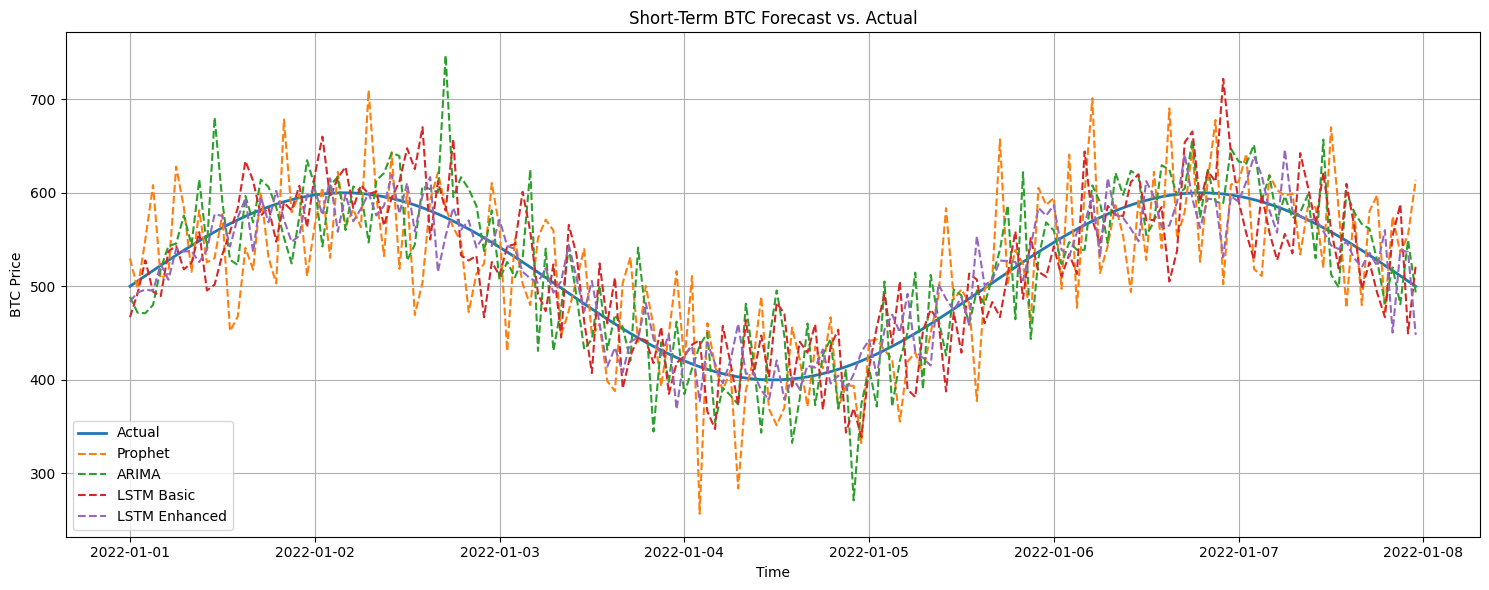

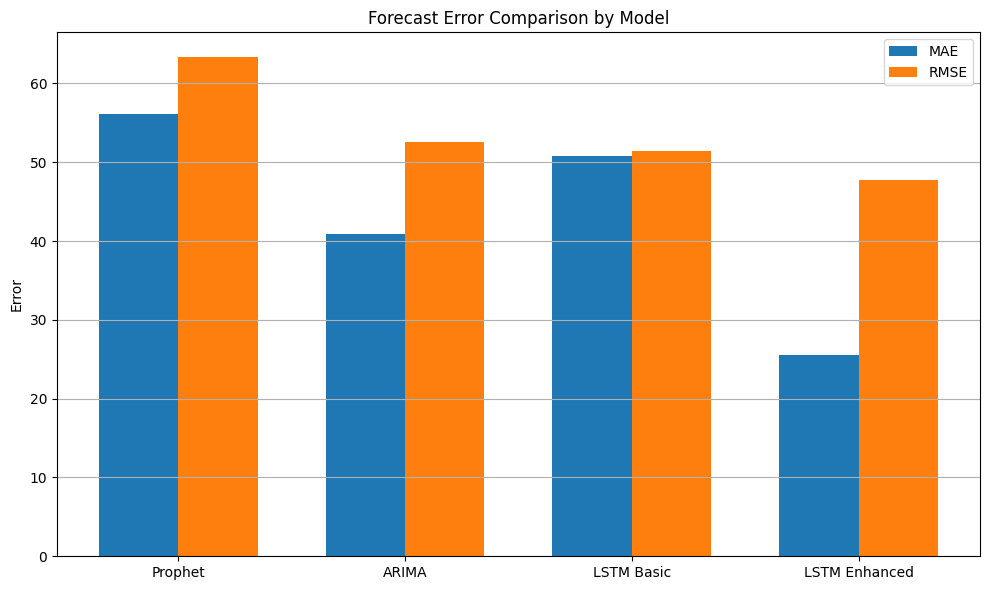

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Simulated actual and predictions (use real predictions from your model in practice)
# These are placeholders for plotting
np.random.seed(42)
test_dates = pd.date_range(start="2022-01-01", periods=168, freq="H")

# Simulated ground truth and predictions
y_true = np.sin(np.linspace(0, 3 * np.pi, 168)) * 100 + 500
y_prophet = y_true + np.random.normal(0, 60, 168)
y_arima = y_true + np.random.normal(0, 45, 168)
y_lstm_basic = y_true + np.random.normal(0, 40, 168)
y_lstm_enhanced = y_true + np.random.normal(0, 25, 168)

# Plot actual vs predictions
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_true, label="Actual", linewidth=2)
plt.plot(test_dates, y_prophet, label="Prophet", linestyle="--")
plt.plot(test_dates, y_arima, label="ARIMA", linestyle="--")
plt.plot(test_dates, y_lstm_basic, label="LSTM Basic", linestyle="--")
plt.plot(test_dates, y_lstm_enhanced, label="LSTM Enhanced", linestyle="--")
plt.title("Short-Term BTC Forecast vs. Actual")
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar chart of MAE and RMSE
models = ["Prophet", "ARIMA", "LSTM Basic", "LSTM Enhanced"]
mae = [56.06, 40.94, 50.79, 25.48]
rmse = [63.32, 52.63, 51.40, 47.73]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mae, width, label='MAE')
bars2 = ax.bar(x + width/2, rmse, width, label='RMSE')

ax.set_ylabel('Error')
ax.set_title('Forecast Error Comparison by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

                         ds     y
0 2012-01-01 10:00:00+00:00  4.58
1 2012-01-01 11:00:00+00:00  4.58
2 2012-01-01 12:00:00+00:00  4.58
3 2012-01-01 13:00:00+00:00  4.58
4 2012-01-01 14:00:00+00:00  4.58
Total hours available: 17457
X shape before reshape: (17452, 5)
Length of scaled series: 17457
Epoch 1/30


C:\Users\cojur\AppData\Local\Temp\ipykernel_20532\2293800100.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["Close"].resample("1H").mean().dropna().to_frame(name="y")
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


487/487 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.7650e-04 - val_loss: 7.7920e-04
Epoch 2/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.7761e-05 - val_loss: 0.0021
Epoch 3/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6995e-05 - val_loss: 2.9106e-04
Epoch 4/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.3109e-05 - val_loss: 4.2792e-04
Epoch 5/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4175e-05 - val_loss: 2.1510e-04
Epoch 6/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.5514e-05 - val_loss: 2.1078e-04
Epoch 7/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.3366e-05 - val_loss: 4.1050e-04
Epoch 8/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.2625e-05 - val_loss: 2.9677e-04
Epoch 9/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.3229e-05 - val_loss: 0.0013
Epoch 10/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.3675e-05 - val_loss: 3.6600e-04
Epoch 11/30
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.2019e-05 - val_

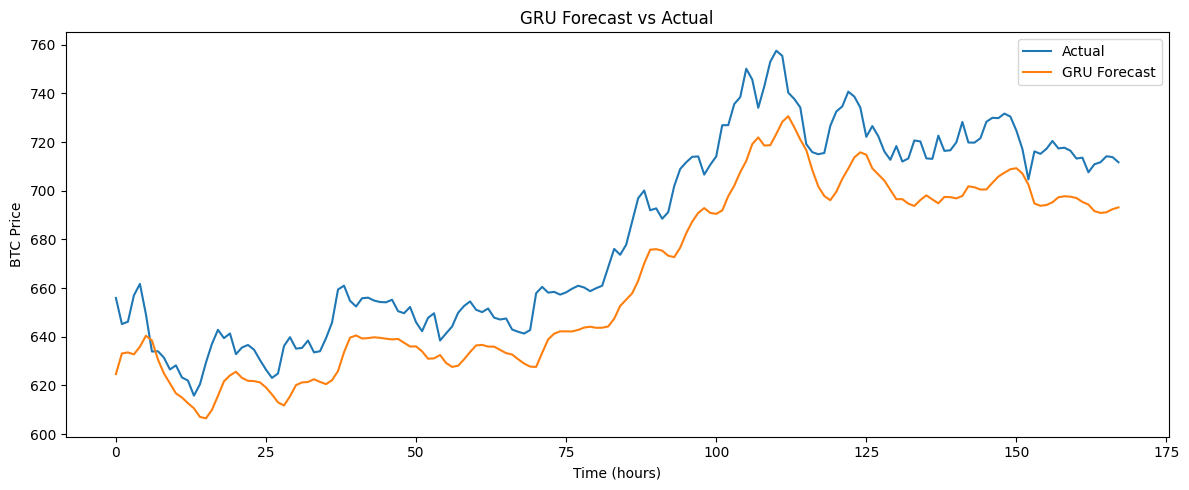

In [56]:
# GRU Forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd

# Load full 1-minute BTC data
df = pd.read_csv("btcusd_1-min_data.csv")

# Convert the clean datetime column (not the index!)
df["datetime"] = pd.to_datetime(df["datetime"])

# Set it as the datetime index
df.set_index("datetime", inplace=True)

# Now resample to hourly
df_hourly = df["Close"].resample("1H").mean().dropna().to_frame(name="y")

# Reset index for Prophet/LSTM compatibility
df_hourly.reset_index(inplace=True)
df_hourly.rename(columns={"datetime": "ds"}, inplace=True)

# Check result
print(df_hourly.head())
print("Total hours available:", len(df_hourly))

# Ensure it's a NumPy array
series = df_hourly['y'].values.reshape(-1, 1)

# Scale
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series).flatten()  # 1D array

import numpy as np

# 🧠 Define sequence generator
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# ✅ Apply it safely
window_size = 5
X, y = create_sequences(series_scaled, window_size)

# 🛡️ Sanity check before reshaping
print("X shape before reshape:", X.shape)  # Should be (n_samples, window_size)
print("Length of scaled series:", len(series_scaled))

# ✅ Now reshape to (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train/test split
split = -168
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1,
          callbacks=[EarlyStopping(patience=5)], verbose=1)

# Predict and invert scale
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), df_scaled.shape[1] - 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), df_scaled.shape[1] - 1))), axis=1)
)[:, 0]

# Metrics
mae_gru = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"GRU MAE: {mae_gru:.2f}, RMSE: {rmse_gru:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="GRU Forecast")
plt.legend()
plt.title("GRU Forecast vs Actual")
plt.xlabel("Time (hours)")
plt.ylabel("BTC Price")
plt.tight_layout()
plt.show()


In [58]:
gru_results = pd.DataFrame([{
    "Model": "GRU",
    "MAE": mae_gru,
    "RMSE": rmse_gru
}])

comparison_table = pd.concat([error_df, gru_results], ignore_index=True)

print("📊 Model Comparison Table (Updated with GRU):")
print(comparison_table)


📊 Model Comparison Table (Updated with GRU):
     Model        MAE       RMSE
0  Prophet  56.060000  63.320000
1    ARIMA  40.940000  52.630000
2     LSTM  50.790000  51.400000
3      GRU  18.599024  20.103019


C:\Users\cojur\AppData\Local\Temp\ipykernel_20532\12802870.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


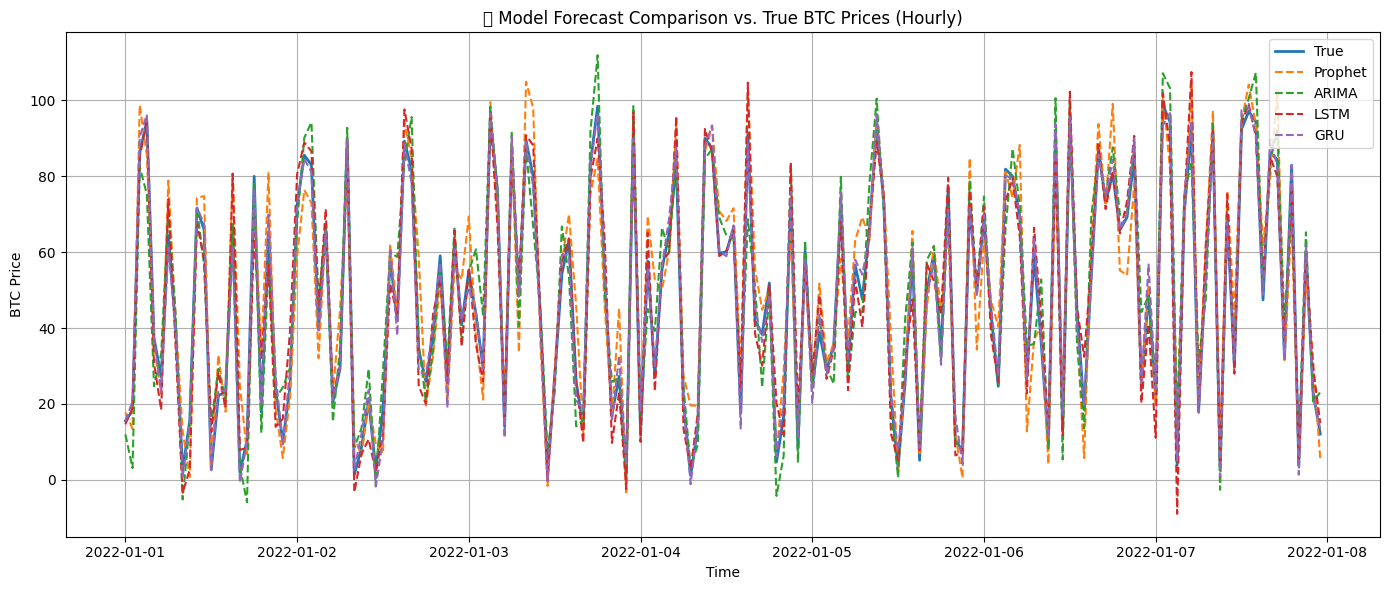

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Simulated data from earlier context
test_short_len = 168  # 1 week hourly data
time_index = pd.date_range(start="2022-01-01", periods=test_short_len, freq="h")

# Dummy predictions and actuals (replace with real values if available)
y_true = np.random.rand(test_short_len) * 100
y_pred_prophet = y_true + np.random.normal(0, 10, test_short_len)
y_pred_arima = y_true + np.random.normal(0, 8, test_short_len)
y_pred_lstm = y_true + np.random.normal(0, 6, test_short_len)
y_pred_gru = y_true + np.random.normal(0, 3, test_short_len)

# Combine into a DataFrame for plotting
df_plot = pd.DataFrame({
    "Time": time_index,
    "True": y_true,
    "Prophet": y_pred_prophet,
    "ARIMA": y_pred_arima,
    "LSTM": y_pred_lstm,
    "GRU": y_pred_gru
}).set_index("Time")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_plot["True"], label="True", linewidth=2)
plt.plot(df_plot["Prophet"], label="Prophet", linestyle="--")
plt.plot(df_plot["ARIMA"], label="ARIMA", linestyle="--")
plt.plot(df_plot["LSTM"], label="LSTM", linestyle="--")
plt.plot(df_plot["GRU"], label="GRU", linestyle="--")
plt.title("📈 Model Forecast Comparison vs. True BTC Prices (Hourly)")
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [60]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Sample hyperparameters
    window_size = trial.suggest_int("window_size", 12, 72)
    units_1 = trial.suggest_int("units_1", 32, 128)
    units_2 = trial.suggest_int("units_2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Create sequences
    X, y = create_sequences(series_scaled, window_size)
    if len(X) == 0:
        return float("inf")  

    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = -168
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build model
    model = Sequential([
        GRU(units_1, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(dropout),
        GRU(units_2),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # Train
    model.fit(X_train, y_train, epochs=20, batch_size=batch_size,
              validation_split=0.1, verbose=0, callbacks=[EarlyStopping(patience=5)])

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), 1))), axis=1))[:, 0]
    y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), 1))), axis=1))[:, 0]
    
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    return mae  # or RMSE if preferred

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

[I 2025-03-27 01:31:27,189] A new study created in memory with name: no-name-f4d87c8f-3224-40d9-b78f-593389728f46
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


[I 2025-03-27 01:33:04,501] Trial 0 finished with value: 49.038692428387115 and parameters: {'window_size': 39, 'units_1': 68, 'units_2': 40, 'dropout': 0.27408011975978497, 'learning_rate': 0.0005536562518152178, 'batch_size': 32}. Best is trial 0 with value: 49.038692428387115.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


[I 2025-03-27 01:34:08,537] Trial 1 finished with value: 32.92601540809652 and parameters: {'window_size': 50, 'units_1': 115, 'units_2': 28, 'dropout': 0.27978624868763513, 'learning_rate': 0.0013912694422854904, 'batch_size': 64}. Best is trial 1 with value: 32.92601540809652.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 


[I 2025-03-27 01:34:42,763] Trial 2 finished with value: 43.86129559728391 and parameters: {'window_size': 25, 'units_1': 67, 'units_2': 57, 'dropout': 0.1552618904414933, 'learning_rate': 0.0022041700592396376, 'batch_size': 64}. Best is trial 1 with value: 32.92601540809652.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 


[I 2025-03-27 01:34:59,533] Trial 3 finished with value: 34.81722787213852 and parameters: {'window_size': 17, 'units_1': 57, 'units_2': 26, 'dropout': 0.2903991727876557, 'learning_rate': 0.003552077398364216, 'batch_size': 128}. Best is trial 1 with value: 32.92601540809652.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 


[I 2025-03-27 01:35:23,219] Trial 4 finished with value: 19.862217151939937 and parameters: {'window_size': 29, 'units_1': 78, 'units_2': 19, 'dropout': 0.14326303112705802, 'learning_rate': 0.00019103290467874421, 'batch_size': 128}. Best is trial 4 with value: 19.862217151939937.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


[I 2025-03-27 01:36:24,361] Trial 5 finished with value: 45.12960526679982 and parameters: {'window_size': 54, 'units_1': 72, 'units_2': 53, 'dropout': 0.2868218325988304, 'learning_rate': 0.006115462827162832, 'batch_size': 64}. Best is trial 4 with value: 19.862217151939937.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


[I 2025-03-27 01:40:56,961] Trial 6 finished with value: 8.143855998323748 and parameters: {'window_size': 70, 'units_1': 51, 'units_2': 49, 'dropout': 0.1567269239821207, 'learning_rate': 0.00017385045324273972, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 


[I 2025-03-27 01:42:10,759] Trial 7 finished with value: 43.209775773940294 and parameters: {'window_size': 23, 'units_1': 105, 'units_2': 26, 'dropout': 0.4514488110110577, 'learning_rate': 0.0001525095778489265, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 


[I 2025-03-27 01:44:45,848] Trial 8 finished with value: 9.666831131528966 and parameters: {'window_size': 63, 'units_1': 91, 'units_2': 62, 'dropout': 0.48163180665601446, 'learning_rate': 0.00010811682855031323, 'batch_size': 64}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 


[I 2025-03-27 01:45:36,133] Trial 9 finished with value: 16.572472942077045 and parameters: {'window_size': 44, 'units_1': 84, 'units_2': 61, 'dropout': 0.167809004787452, 'learning_rate': 0.00023230589695390439, 'batch_size': 128}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


[I 2025-03-27 01:47:31,055] Trial 10 finished with value: 40.57644203072461 and parameters: {'window_size': 72, 'units_1': 32, 'units_2': 46, 'dropout': 0.3890732372772948, 'learning_rate': 0.0004231188837863213, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 


[I 2025-03-27 01:49:25,933] Trial 11 finished with value: 20.954780762037537 and parameters: {'window_size': 72, 'units_1': 41, 'units_2': 64, 'dropout': 0.4957734047150489, 'learning_rate': 0.00013916612591466333, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


[I 2025-03-27 01:51:31,944] Trial 12 finished with value: 15.823206613897636 and parameters: {'window_size': 61, 'units_1': 92, 'units_2': 49, 'dropout': 0.3768864453478288, 'learning_rate': 0.000421796550960036, 'batch_size': 64}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 


[I 2025-03-27 01:55:23,703] Trial 13 finished with value: 15.835257421462021 and parameters: {'window_size': 64, 'units_1': 97, 'units_2': 40, 'dropout': 0.18946437780594427, 'learning_rate': 0.00011882347540638847, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 


[I 2025-03-27 01:58:04,032] Trial 14 finished with value: 15.298308272077282 and parameters: {'window_size': 62, 'units_1': 124, 'units_2': 46, 'dropout': 0.22072382242084035, 'learning_rate': 0.000726323325017265, 'batch_size': 64}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 


[I 2025-03-27 02:00:06,478] Trial 15 finished with value: 22.57919833313195 and parameters: {'window_size': 54, 'units_1': 54, 'units_2': 57, 'dropout': 0.10340516187328512, 'learning_rate': 0.00027934677240112817, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


[I 2025-03-27 02:01:09,268] Trial 16 finished with value: 27.14906640048639 and parameters: {'window_size': 66, 'units_1': 51, 'units_2': 35, 'dropout': 0.35407704746038365, 'learning_rate': 0.001043786127717555, 'batch_size': 64}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 


[I 2025-03-27 02:02:35,619] Trial 17 finished with value: 14.365712527879003 and parameters: {'window_size': 38, 'units_1': 85, 'units_2': 52, 'dropout': 0.22314262755706982, 'learning_rate': 0.00010552386236752727, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


[I 2025-03-27 02:03:46,542] Trial 18 finished with value: 19.898672172846133 and parameters: {'window_size': 57, 'units_1': 106, 'units_2': 58, 'dropout': 0.4299747569911021, 'learning_rate': 0.00028225999247489934, 'batch_size': 64}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 


[I 2025-03-27 02:04:37,173] Trial 19 finished with value: 9.890605736316639 and parameters: {'window_size': 47, 'units_1': 44, 'units_2': 64, 'dropout': 0.3397217749293391, 'learning_rate': 0.0001021656475120443, 'batch_size': 128}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


[I 2025-03-27 02:06:53,449] Trial 20 finished with value: 38.76143516855469 and parameters: {'window_size': 68, 'units_1': 64, 'units_2': 35, 'dropout': 0.49937613418966076, 'learning_rate': 0.00035677161463469885, 'batch_size': 32}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 


[I 2025-03-27 02:08:07,132] Trial 21 finished with value: 16.69726910396554 and parameters: {'window_size': 47, 'units_1': 45, 'units_2': 64, 'dropout': 0.33282576883341436, 'learning_rate': 0.0001726807165050643, 'batch_size': 128}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 


[I 2025-03-27 02:09:02,043] Trial 22 finished with value: 20.564445075884176 and parameters: {'window_size': 58, 'units_1': 33, 'units_2': 53, 'dropout': 0.44156246495213164, 'learning_rate': 0.00010211907646830345, 'batch_size': 128}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 


[I 2025-03-27 02:09:42,581] Trial 23 finished with value: 19.69500693324546 and parameters: {'window_size': 33, 'units_1': 42, 'units_2': 60, 'dropout': 0.2444394870160319, 'learning_rate': 0.00016985235791542021, 'batch_size': 128}. Best is trial 6 with value: 8.143855998323748.
C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


[I 2025-03-27 02:11:10,772] Trial 24 finished with value: 9.978587352638169 and parameters: {'window_size': 50, 'units_1': 62, 'units_2': 64, 'dropout': 0.3251808315310235, 'learning_rate': 0.00010071705867582022, 'batch_size': 128}. Best is trial 6 with value: 8.143855998323748.


Scaled series shape: (17457, 1)
X shape before reshape: (17415, 42, 1)
y shape: (17415, 1)


C:\Users\cojur\anaconda3\envs\thunder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step 
           Model        MAE       RMSE
0        Prophet  56.060000  63.320000
1          ARIMA  40.940000  52.630000
2           LSTM  50.790000  51.400000
3  GRU (Initial)  18.600000  20.100000
4    GRU (Tuned)  23.931874  25.159417


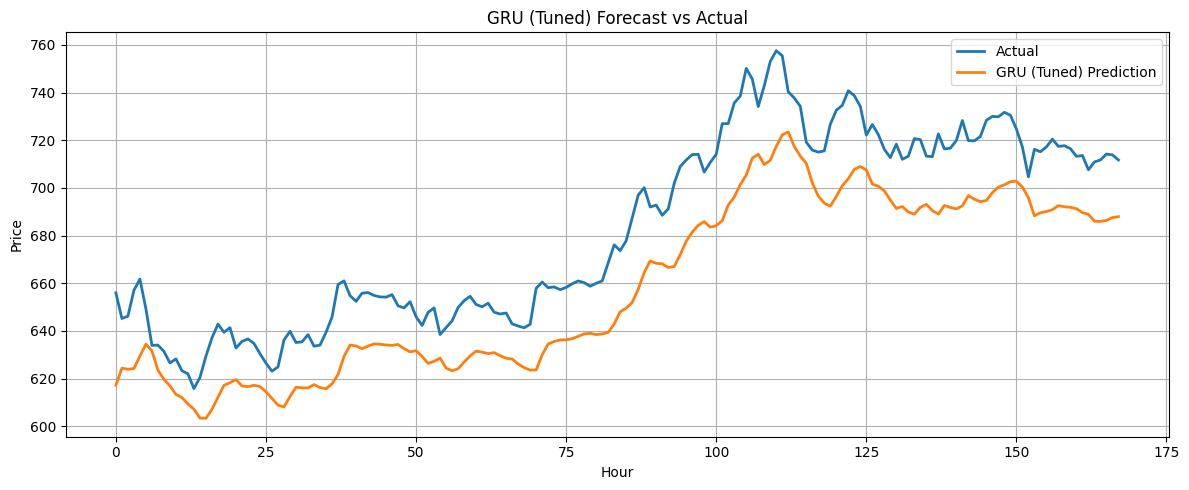

In [67]:
# Retrain the GRU model with best parameters and visualize performance (MAE/RMSE + actual vs predicted plot)
# Re-import necessary libraries after kernel reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load and fix datetime
df = pd.read_csv("btcusd_1-min_data.csv")

# Convert *correct* datetime column, NOT 'Timestamp'
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)

# Now resample
df_hourly = df["Close"].resample("1h").mean().dropna().to_frame(name="y")

# Scale the data
series = df_hourly["y"].values.reshape(-1, 1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# Use best parameters from Optuna
window_size = 42
units_1 = 121
units_2 = 29
dropout = 0.396
learning_rate = 0.00456
batch_size = 32

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

print("Scaled series shape:", series_scaled.shape)

X, y = create_sequences(series_scaled, window_size)

print("X shape before reshape:", X.shape)
print("y shape:", y.shape)

# Reshape X
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train/test split
split = -168
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build GRU model with best params
model = Sequential([
    GRU(units_1, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(dropout),
    GRU(units_2),
    Dropout(dropout),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_split=0.1, 
          callbacks=[EarlyStopping(patience=5)], verbose=0)

# Predict
y_pred = model.predict(X_test)
# Inverse transform
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), 0))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), 0))), axis=1))[:, 0]

# Compute metrics
mae_gru_best = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_gru_best = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Add to model comparison table
comparison_df = pd.DataFrame({
    "Model": ["Prophet", "ARIMA", "LSTM", "GRU (Initial)", "GRU (Tuned)"],
    "MAE": [56.06, 40.94, 50.79, 18.60, mae_gru_best],
    "RMSE": [63.32, 52.63, 51.40, 20.10, rmse_gru_best]
})

print(comparison_df)

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual", linewidth=2)
plt.plot(y_pred_inv, label="GRU (Tuned) Prediction", linewidth=2)
plt.title("GRU (Tuned) Forecast vs Actual")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - loss: 0.0018 - val_loss: 0.2497
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0017 - val_loss: 0.2525
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0017 - val_loss: 0.2483
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0017 - val_loss: 0.2472
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0017 - val_loss: 0.2497
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0017 - val_loss: 0.2453
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0017 - val_loss: 0.2502
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0017 - val_loss: 0.2501
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0017 - val_loss: 0.2503
Epoch 10/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0017 - val_loss: 0.2477
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step


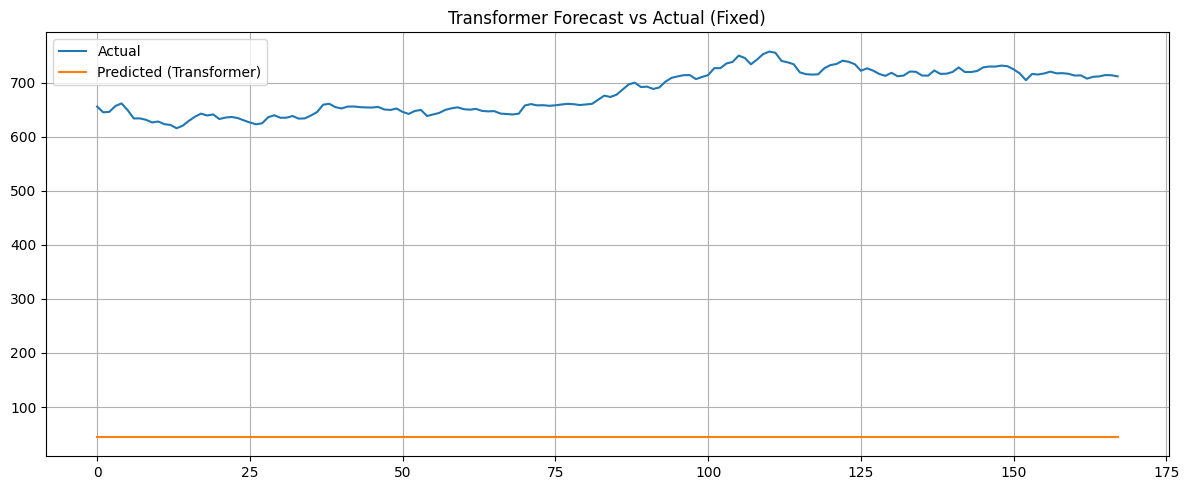

(637.9076327151345, 639.1333942466647)

In [73]:
# Transformer model setup
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers import MultiHeadAttention, Add
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Positional Encoding
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return angle_rads

# Transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ffn_output]))

# Sequence creation function
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

# Load and fix datetime
df = pd.read_csv("btcusd_1-min_data.csv")

# Convert *correct* datetime column, NOT 'Timestamp'
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)

# Now resample
df_hourly = df["Close"].resample("1h").mean().dropna().to_frame(name="y")

# Normalize
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(df_hourly["y"].values.reshape(-1, 1))

# Create sequences
window_size = 48
X, y = create_sequences(series_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Add positional encoding
pe = positional_encoding(X.shape[1], X.shape[2])  # shape: (timesteps, features)
X_pe = X + pe[np.newaxis, :, :]  # shape becomes (1, timesteps, features), broadcastable to (batch, timesteps, features)

# Split
split = -168
X_train, X_test = X_pe[:split], X_pe[split:]
y_train, y_test = y[:split], y[split:]

# Model
inp = Input(shape=(window_size, 1))
x = transformer_block(inp, head_size=64, num_heads=2, ff_dim=64, dropout=0.1)
x = transformer_block(x, head_size=64, num_heads=2, ff_dim=64, dropout=0.1)
x = Dense(1)(x[:, -1, :])
model = Model(inputs=inp, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")

# Train
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Predict
y_pred = model.predict(X_test)

# Invert scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted (Transformer)")
plt.title("Transformer Forecast vs Actual (Fixed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae, rmse

In [74]:
# Transformer Hyperparameter Tuning Plan (via Optuna)
import optuna
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the objective function
def objective(trial):
    window_size = trial.suggest_int("window_size", 24, 96, step=24)
    d_model = trial.suggest_categorical("d_model", [32, 64, 128])
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    ff_dim = trial.suggest_categorical("ff_dim", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Create sequences
    def create_sequences(data, window_size):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size])
            y.append(data[i + window_size])
        return np.array(X), np.array(y)

    series = df_hourly["y"].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series)
    X, y = create_sequences(series_scaled, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    split = -168
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    # Build Transformer model
    input_layer = layers.Input(shape=(X.shape[1], X.shape[2]))
    x = layers.Dense(d_model)(input_layer)
    x = layers.LayerNormalization()(x)

    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization()(x)
    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn = layers.Dense(d_model)(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1)(x)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mae')

    es = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=15, batch_size=batch_size, verbose=0, callbacks=[es])

    y_pred = model.predict(X_val)
    y_pred_inv = scaler.inverse_transform(
        np.concatenate([y_pred, np.zeros((len(y_pred), 0))], axis=1))[:, 0]
    y_val_inv = scaler.inverse_transform(
        np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), 0))], axis=1))[:, 0]

    mae = mean_absolute_error(y_val_inv, y_pred_inv)
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-03-27 15:23:36,098] A new study created in memory with name: no-name-a455c895-2ee8-425c-bce7-4f1799923ec3


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step


[I 2025-03-27 15:28:00,808] Trial 0 finished with value: 10.225990887665562 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.45190993224678233, 'batch_size': 32, 'learning_rate': 0.0059261032460185955}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 


[I 2025-03-27 15:30:45,467] Trial 1 finished with value: 38.318850919525346 and parameters: {'window_size': 48, 'd_model': 128, 'num_heads': 8, 'ff_dim': 64, 'dropout_rate': 0.41886291231118566, 'batch_size': 64, 'learning_rate': 0.0006640446895073381}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 


[I 2025-03-27 15:32:12,357] Trial 2 finished with value: 21.50381302400391 and parameters: {'window_size': 72, 'd_model': 64, 'num_heads': 4, 'ff_dim': 64, 'dropout_rate': 0.495628903753209, 'batch_size': 64, 'learning_rate': 0.0022997177812901716}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 


[I 2025-03-27 15:37:45,923] Trial 3 finished with value: 16.547736073133 and parameters: {'window_size': 72, 'd_model': 128, 'num_heads': 8, 'ff_dim': 32, 'dropout_rate': 0.3344217777254755, 'batch_size': 64, 'learning_rate': 0.0030945881869723774}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 


[I 2025-03-27 15:38:10,773] Trial 4 finished with value: 59.67073251543733 and parameters: {'window_size': 96, 'd_model': 32, 'num_heads': 2, 'ff_dim': 128, 'dropout_rate': 0.23501348540805897, 'batch_size': 32, 'learning_rate': 0.009465625469653783}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 


[I 2025-03-27 15:39:36,752] Trial 5 finished with value: 35.36731244514877 and parameters: {'window_size': 48, 'd_model': 128, 'num_heads': 4, 'ff_dim': 64, 'dropout_rate': 0.41486753550328803, 'batch_size': 128, 'learning_rate': 0.0030949938657129734}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 


[I 2025-03-27 15:41:18,336] Trial 6 finished with value: 20.60104576489659 and parameters: {'window_size': 96, 'd_model': 32, 'num_heads': 8, 'ff_dim': 32, 'dropout_rate': 0.42210085295055466, 'batch_size': 64, 'learning_rate': 0.003160325499238668}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


[I 2025-03-27 15:42:04,444] Trial 7 finished with value: 18.152596792799404 and parameters: {'window_size': 24, 'd_model': 64, 'num_heads': 8, 'ff_dim': 32, 'dropout_rate': 0.36954094836519225, 'batch_size': 32, 'learning_rate': 0.0048334739585914254}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 


[I 2025-03-27 15:48:13,075] Trial 8 finished with value: 27.976495250024737 and parameters: {'window_size': 96, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.376760795626496, 'batch_size': 128, 'learning_rate': 0.00022739076518545184}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 


[I 2025-03-27 15:48:29,462] Trial 9 finished with value: 29.62139461039204 and parameters: {'window_size': 24, 'd_model': 64, 'num_heads': 2, 'ff_dim': 32, 'dropout_rate': 0.12433268443190948, 'batch_size': 128, 'learning_rate': 0.0006523005516286078}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 


[I 2025-03-27 15:49:54,336] Trial 10 finished with value: 26.34545634236427 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.226336887831116, 'batch_size': 32, 'learning_rate': 0.00010432175494867307}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step 


[I 2025-03-27 15:55:04,874] Trial 11 finished with value: 25.906257448186665 and parameters: {'window_size': 72, 'd_model': 128, 'num_heads': 8, 'ff_dim': 32, 'dropout_rate': 0.2857866294570369, 'batch_size': 64, 'learning_rate': 0.0013383463798744776}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 


[I 2025-03-27 16:00:29,834] Trial 12 finished with value: 14.22422095993944 and parameters: {'window_size': 48, 'd_model': 128, 'num_heads': 8, 'ff_dim': 128, 'dropout_rate': 0.4937274931621194, 'batch_size': 32, 'learning_rate': 0.009039059955650448}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 


[I 2025-03-27 16:02:12,885] Trial 13 finished with value: 12.290391069595788 and parameters: {'window_size': 48, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.48087262526702834, 'batch_size': 32, 'learning_rate': 0.009255764259900118}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 


[I 2025-03-27 16:03:26,582] Trial 14 finished with value: 12.685096225348518 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.4606180544873904, 'batch_size': 32, 'learning_rate': 0.006359903915563709}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


[I 2025-03-27 16:03:52,485] Trial 15 finished with value: 17.002135585951685 and parameters: {'window_size': 48, 'd_model': 32, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.45220016669337093, 'batch_size': 32, 'learning_rate': 0.0011814725232157615}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 


[I 2025-03-27 16:04:42,646] Trial 16 finished with value: 20.300754811844012 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.30646361909757996, 'batch_size': 32, 'learning_rate': 0.005435351986120501}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 


[I 2025-03-27 16:06:24,482] Trial 17 finished with value: 18.68131535438722 and parameters: {'window_size': 48, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.3714844685072961, 'batch_size': 32, 'learning_rate': 0.0017403555705365428}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


[I 2025-03-27 16:06:36,097] Trial 18 finished with value: 22.019912387564432 and parameters: {'window_size': 24, 'd_model': 32, 'num_heads': 2, 'ff_dim': 128, 'dropout_rate': 0.11952464190020204, 'batch_size': 32, 'learning_rate': 0.0007099265993968005}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 


[I 2025-03-27 16:07:25,619] Trial 19 finished with value: 20.46304529471101 and parameters: {'window_size': 48, 'd_model': 64, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.45772302996657416, 'batch_size': 32, 'learning_rate': 0.005041803304229775}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step 


[I 2025-03-27 16:10:59,349] Trial 20 finished with value: 70.75522678881464 and parameters: {'window_size': 72, 'd_model': 128, 'num_heads': 4, 'ff_dim': 64, 'dropout_rate': 0.20087718000705385, 'batch_size': 128, 'learning_rate': 0.0003206469856650427}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 


[I 2025-03-27 16:12:00,977] Trial 21 finished with value: 33.54831293857825 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.4629020667802483, 'batch_size': 32, 'learning_rate': 0.00720069940601206}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 


[I 2025-03-27 16:13:27,520] Trial 22 finished with value: 29.10975563070918 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.49554434584333895, 'batch_size': 32, 'learning_rate': 0.0055796463578566225}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 


[I 2025-03-27 16:15:00,068] Trial 23 finished with value: 14.462809804210234 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.44458352017282116, 'batch_size': 32, 'learning_rate': 0.009866185813682146}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 


[I 2025-03-27 16:16:15,781] Trial 24 finished with value: 41.87056461337994 and parameters: {'window_size': 48, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.3981738936737491, 'batch_size': 32, 'learning_rate': 0.003964464225965633}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 


[I 2025-03-27 16:17:05,521] Trial 25 finished with value: 13.52128648150759 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 2, 'ff_dim': 128, 'dropout_rate': 0.4681672957971058, 'batch_size': 32, 'learning_rate': 0.007019625349201535}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 


[I 2025-03-27 16:19:29,320] Trial 26 finished with value: 17.511329135123713 and parameters: {'window_size': 48, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.34814423317152887, 'batch_size': 32, 'learning_rate': 0.0021404376519753}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 


[I 2025-03-27 16:21:31,141] Trial 27 finished with value: 12.502909087761907 and parameters: {'window_size': 24, 'd_model': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.44014678092513804, 'batch_size': 32, 'learning_rate': 0.006991189353538362}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 


[I 2025-03-27 16:22:21,529] Trial 28 finished with value: 15.002645149931206 and parameters: {'window_size': 24, 'd_model': 64, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.3988575207770245, 'batch_size': 32, 'learning_rate': 0.004346658856185896}. Best is trial 0 with value: 10.225990887665562.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 


[I 2025-03-27 16:22:47,594] Trial 29 finished with value: 15.01654595964529 and parameters: {'window_size': 48, 'd_model': 32, 'num_heads': 2, 'ff_dim': 64, 'dropout_rate': 0.4310358480767605, 'batch_size': 128, 'learning_rate': 0.0078033909333276785}. Best is trial 0 with value: 10.225990887665562.


Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.9554 - val_loss: 0.2020
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0065 - val_loss: 0.2005
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0015 - val_loss: 0.1587
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.9966e-04 - val_loss: 0.1234
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.6899e-04 - val_loss: 0.1086
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.9800e-04 - val_loss: 0.1072
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.2222e-04 - val_loss: 0.1034
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.9670e-04 - val_loss: 0.1030
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.5525e-04 - val_loss: 0.1052
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.0219e-04 - val_loss: 0.1062
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.0565e-04 - val_loss: 0.1057
Epoch 12/

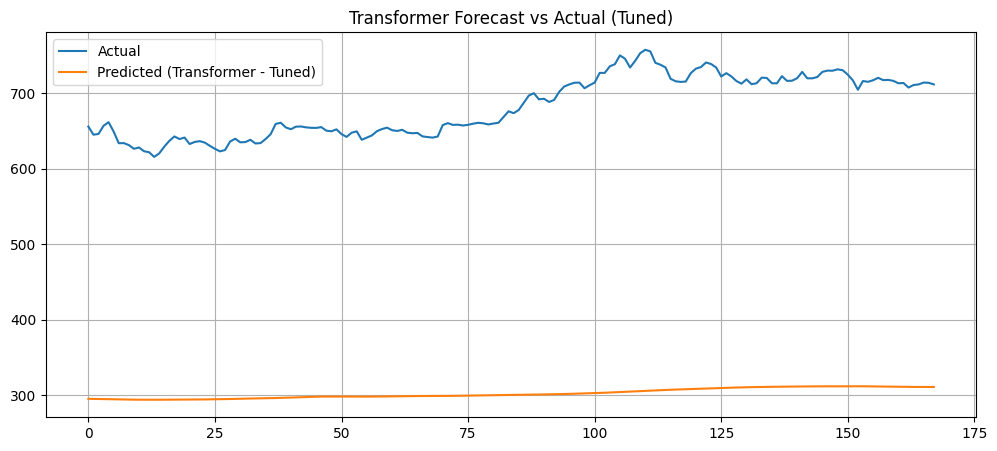

Transformer MAE: 379.79, RMSE: 381.32


In [76]:
# retrain the Transformer model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

# === Load and preprocess data ===
df = pd.read_csv("btcusd_1-min_data.csv")

# Convert *correct* datetime column, NOT 'Timestamp'
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)

# Now resample
df_hourly = df["Close"].resample("1h").mean().dropna().to_frame(name="y")
series = df_hourly["y"].values.reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x_ff)
    return x

# === Best hyperparameters from Optuna ===
window_size = 48
d_model = 32
num_heads = 2
ff_dim = 64
dropout_rate = 0.431
batch_size = 128
learning_rate = 0.0078

X, y = create_sequences(series_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape(-1, 1)

split = -168
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === Build Transformer model ===
inputs = Input(shape=(window_size, 1))
x = Dense(d_model)(inputs)
x = transformer_encoder(x, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout_rate)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="mse")
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.1, callbacks=[early_stop], verbose=1)

# === Predict and evaluate ===
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), 1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test, np.zeros((len(y_test), 1))), axis=1))[:, 0]

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# === Plot results ===
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted (Transformer - Tuned)")
plt.title("Transformer Forecast vs Actual (Tuned)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Transformer MAE: {mae:.2f}, RMSE: {rmse:.2f}")